In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np
import spacy

/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-28 22:23:34.167133: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 22:23:34.392716: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-28 22:23:34.392750: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
202

## Chargement des données

In [ ]:
train = pd.read_csv('BUILD/train.csv')
dev = pd.read_csv('BUILD/dev.csv')

## Extraction des descripteurs

Le ColumnTransformer permet de calculer des descripteurs simplement à partir d'un dataframe.
Il s'agit d'une liste de 3 élements:
    - le nom du descripteur (str)
    - une fonction ou un objet scikit-learn qui implémente `fit` et ou `transform`
    - la colonne à utiliser

Par exemple pour le descripteur `sentence_position`, on va utiliser la colonne `sentence_percent` directement (`passthrough`) (il faut utiliser des crochets pour que la taille du vecteur soit correcte).

In [ ]:
# Cette fonction reçoit les colonnes choisies pour tout les exemples
# et renvoie un array numpy avec de taille (nb_exemple, nb_features)
def sentence_position(df):
    # print(df.shape, df.columns)
    
    # calcule le nombre de phrase par document dans un dictionnaire
    doc2nbsent = df.groupby('doc_id')['sentence_index'].max().to_dict()
    # crée une colonne qui associe à chaque document_id le nombre de phrase du document
    df['nb_sent'] = df['doc_id'].map(doc2nbsent.get)
    # calcul le rapport entre l'indice de la phrase et le nombre total de phrases
    position = df['sentence_index'] / df['nb_sent']

    # Converti la colonne pandas (pd.Series) en array numpy (np.ndarray) puis lui
    # donne la taille (n_samples, n_features_new), -1 représente le nombre d'élément
    # original et 1 la nouvelle feature que l'on a créée
    return position.values.reshape(-1, 1)

Pour tester sentence_pos :

In [ ]:
# Créez un petit dataframe d'exemple
data_test = {
    'doc_id': [1, 1, 1, 2, 2],
    'sentence_index': [0, 1, 2, 0, 1],
    'text': ['This is the first sentence.', 'Here is the second sentence.', 'And this is the third sentence.', 'Another document starts here.', 'This is the second sentence of the second document.']
}

df = pd.DataFrame(data_test)

# Appelez la fonction sentence_position sur le dataframe
position_features = sentence_position(df)

# Affichez le résultat
print(position_features)
print(type(position_features))


[[0. ]
 [0.5]
 [1. ]
 [0. ]
 [1. ]]
<class 'numpy.ndarray'>


In [ ]:
def contains_ldots(sentence):
    return 1 if '...' in sentence else 0

In [ ]:
dev['contains_ldots'] = dev['text'].map(contains_ldots)
train['contains_ldots'] = train['text'].map(contains_ldots)

Ajout du descripteur Sentence Length:

In [ ]:
# Fonction pour extraire la longueur de chaque phrase en nombre de mots
def sentence_length(df):
    # Utilisez la fonction str.split() pour diviser chaque phrase en mots et compter leur nombre
    lengths = df['text'].apply(lambda x: len(x.split()))
    # Convertissez la colonne pandas en array numpy et redimensionnez-la
    return lengths.values.reshape(-1, 1)


In [ ]:
!python -m spacy download en_core_web_sm

2023-09-28 22:23:40.399843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 22:23:40.558087: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-09-28 22:23:40.558127: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-09-28 22:23:40.593100: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-09-28 22:23:41.371214: W tensorflow/stream_executor/pla

In [ ]:
# Identifie le verbe principal de la phrase et son temps
# Chargez le modèle spaCy
nlp = spacy.load("en_core_web_sm")

# Créez un dictionnaire pour mapper les types de verbes à des valeurs numériques
verb_tense_mapping = {
    "VB": 1,
    "VBD": 2,
    "VBG": 3,
    "VBN": 4,
    "VBP": 5,
    "VBZ": 6,
}

# Fonction pour extraire la tense verbale de chaque phrase et la redimensionner
def extract_verb_tense(df):
    verb_tenses = []
    for text in df['text']:
        doc = nlp(text)
        # Comptez les occurrences de chaque tense verbale dans la phrase
        verb_tense_counts = {tense: 0 for tense in verb_tense_mapping}
        for token in doc:
            if token.pos_ == "VERB" and token.tag_ in verb_tense_mapping:
                verb_tense_counts[token.tag_] += 1
        # Trouvez la tense verbale la plus fréquente dans la phrase
        most_common_tense = max(verb_tense_counts, key=verb_tense_counts.get)
        # Encodez la tense verbale en valeur numérique
        encoded_tense = verb_tense_mapping.get(most_common_tense, 0)  # 0 par défaut si non trouvé
        verb_tenses.append(encoded_tense)
    
    # Convertissez la liste en un tableau numpy
    verb_tenses_np = np.array(verb_tenses).reshape(-1, 1)
    
    return verb_tenses_np

In [ ]:
for v in verb_tense_mapping :
    print(v,spacy.explain(v))

VB verb, base form
VBD verb, past tense
VBG verb, gerund or present participle
VBN verb, past participle
VBP verb, non-3rd person singular present
VBZ verb, 3rd person singular present


Pour tester extract_verb_tense:

In [ ]:
# Exemple de DataFrame
data_test2 = {
    'text': [
        "She walks to the park.",
        "They walked in the rain.",
        "I am writing a letter.",
    ]
}

df_test2 = pd.DataFrame(data_test2)

# Utilisez la fonction extract_verb_tense pour obtenir les tense verbaux
verb_tenses_result = extract_verb_tense(df_test2)

# Créez un nouveau DataFrame avec les résultats


# Affichez le résultat
print(verb_tenses_result)


[[6]
 [2]
 [3]]


Descripteur basé sur le word embeding:


In [ ]:
# Fonction pour extraire les embeddings de chaque phrase
def extract_spacy_embeddings(df):
    embeddings = []
    for text in df['text']:
        doc = nlp(text)
        # Obtenez le vecteur d'embedding du document (phrase)
        embeddings.append(doc.vector)
    
    # Convertissez la liste de vecteurs en un tableau numpy
    embeddings_np = np.array(embeddings)
    
    return embeddings_np

In [ ]:
# Créez un exemple de DataFrame avec une colonne 'text'
data = {'text': ["I enjoy reading books.", "Machine learning is fascinating."]}
df = pd.DataFrame(data)

# Appelez la fonction pour extraire les embeddings de mots
result = extract_spacy_embeddings(df)

# Affichez le résultat
print(result)

[[-4.80060399e-01 -5.98375797e-02 -3.87243688e-01 -1.44997120e-01
  -1.03505373e-01  4.01043564e-01  3.68491888e-01  3.81586939e-01
  -5.32597192e-02 -1.23038471e-01 -2.84192175e-01 -2.57729620e-01
   4.62596230e-02 -3.78694475e-01 -1.39936373e-01 -8.21346164e-01
   5.47067046e-01  1.13798514e-01  4.00418580e-01 -2.84472406e-01
   6.29525423e-01 -5.14032245e-01  5.52743137e-01  2.19274715e-01
   2.96081960e-01  9.30526078e-01 -6.80817217e-02 -3.17534924e-01
  -9.42544565e-02  1.42281681e-01 -6.74207434e-02  1.29743218e+00
  -1.36005938e-01 -1.78422257e-01 -1.78431436e-01  3.30633998e-01
  -2.60016024e-01 -2.41962790e-01 -4.70419794e-01  4.42000538e-01
   3.80791962e-01  8.46531093e-01  9.78510156e-02 -2.24401996e-01
  -2.84400228e-02 -4.13949728e-01 -2.06411391e-01  5.41278064e-01
  -5.82863033e-01  5.13919532e-01 -3.84063184e-01  4.78164665e-02
   1.28304511e-01  2.51944602e-01 -4.34382141e-01 -3.48645747e-01
   1.77799612e-01  3.41256201e-01 -7.25419372e-02 -1.37883544e-01
  -7.62700

In [ ]:
# Il y a plusieurs manières de combiner les descripteurs:
# - utiliser des objets de SkLearn (comme le CountVectorizer)
# - utiliser un FunctionTransformer qui prend en entrée une fonction qui va créer le descripteur à la volée
# - utiliser le mot-clé "passthrough" pour les descripteurs précaculés
column_trans = ColumnTransformer(
    [
        (
            "count_vectorizer",
            CountVectorizer(stop_words='english',ngram_range=(1,3), min_df=10),
            "text",
        ),
        (
            "single_values",
            'passthrough', # passthrough permet de passer les colonnes sans les transformer
            ["contains_ldots"],  # ajoutez d'autre noms de colonnes
        ),
        (
            "Tfidf Vectorizer",
            TfidfVectorizer(stop_words='english', ngram_range=(1, 3), min_df=10),
            "text",
        ),
        (
            'sentence_position', # nom du descripteur
            FunctionTransformer(sentence_position),
            ['doc_id', 'sentence_index'],  # les colonnes à transmettre à la fonction sentence_position
        ),
        (
            'Verb Tense',
            FunctionTransformer(extract_verb_tense),
            ['text'],  # Colonnes de texte pour lesquelles vous voulez extraire la tense verbale
        ),
        (
            'Word embedding',
            FunctionTransformer(extract_spacy_embeddings),
            ['text'],  # Colonnes de texte pour lesquelles vous voulez extraire la tense verbale
        ),
        
        #(
        #    'Sentence Length', # descripteur de longueur de phrase 
        #    FunctionTransformer(sentence_length),
        #    ['text'],  # Colonnes de texte pour lesquelles vous voulez calculer la longueur
        #),

    ],
    remainder="drop",
)

# Ici on crée un pipeline qui va extraire les descripteurs puis entraîner ou prédire
classifier = make_pipeline(
    column_trans,
    LogisticRegression(multi_class="multinomial")
)

## Entraînement

In [ ]:
# On entraîne le modèle sur les 100 premiers exemples.
classifier.fit(train, train['labels'])

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('count_vectorizer',
                                                  CountVectorizer(min_df=10,
                                                                  ngram_range=(1,
                                                                               3),
                                                                  stop_words='english'),
                                                  'text'),
                                                 ('single_values',
                                                  'passthrough',
                                                  ['contains_ldots']),
                                                 ('Tfidf Vectorizer',
                                                  TfidfVectorizer(min_df=10,
                                                                  ngram_range=(1,
                                                                               3),
                                                                  stop_words='english'),
                                                  'text'),
                                                 ('sentence_position',
                                                  FunctionTransformer(func=<function sentence_position at 0x7f3a5277d5e0>),
                                                  ['doc_id', 'sentence_index']),
                                                 ('Verb Tense',
                                                  FunctionTransformer(func=<function extract_verb_tense at 0x7f3a5279a5e0>),
                                                  ['text']),
                                                 ('Word embedding',
                                                  FunctionTransformer(func=<function extract_spacy_embeddings at 0x7f3b1d6c8a60>),
                                                  ['text'])])),
                ('logisticregression',
                 LogisticRegression(multi_class='multinomial'))])

## Prédiction

In [ ]:
# Prédit puis choisis l'étiquette qui a la plus haut probabilité
dev['pred'] = classifier.predict(dev)
train['pred'] = classifier.predict(train)

In [ ]:
# Pour obtenir le nom des étiquettes prédites
# On récupère le nom et l'ordre des étiquettes
index2label = classifier.named_steps['logisticregression'].classes_


# Retourne la probabilité pour chacune des étiquettes
predictions_prob = classifier.predict_proba(dev.iloc[:10])
# On choisis l'étiquette avec la plus haute probabilité
index_max_predictions = predictions_prob.argmax(axis=1).tolist()

# Ces deux liste devraient être les mêmes
print([index2label[l] for l in index_max_predictions])
print(classifier.predict(dev.iloc[:10]).tolist())

['ANALYSIS', 'ANALYSIS', 'RPC', 'RPC', 'RPC', 'NONE', 'PREAMBLE', 'NONE', 'NONE', 'ANALYSIS']
['ANALYSIS', 'ANALYSIS', 'RPC', 'RPC', 'RPC', 'NONE', 'PREAMBLE', 'NONE', 'NONE', 'ANALYSIS']


In [ ]:
train

,doc_id,doc_index,sentence_index,annotation_id,text,meta_group,labels,contains_ldots,pred
0,1735,0,0,d7a902fe9c23417499a7ef782f9fbdeb,"IN THE HIGH COURT OF KARNATAKA,\n ...",Criminal,PREAMBLE,0,PREAMBLE
1,1735,0,1,8d41599e98424d9480c25109556a7d14,\n\n BEFORE\n\nTHE HON'BLE MR.JUSTICE ANA...,Criminal,PREAMBLE,0,PREAMBLE
2,1735,0,2,e501424117da40a7935c2d9f2fb2fe38,This Criminal Appeal is filed under Section 37...,Criminal,PREAMBLE,0,PREAMBLE
3,1735,0,3,4825806388fe43d39f73354b10b5b32d,\n\n This appeal coming on for hearing t...,Criminal,PREAMBLE,0,PREAMBLE
4,1735,0,4,d6893a25f82948f8be17fc9e876fb716,\n Heard the learned Counsel for the app...,Criminal,NONE,0,NONE
...,...,...,...,...,...,...,...,...,...
26082,4115,222,47,ed1047495bd141b787dc82f1c122171a,"As such, the High Court of Gujarath held that ...",Tax,ANALYSIS,0,ANALYSIS
26083,4115,222,48,79a753a82c5f4ea8a3c2ce0e241e15e9,"\n 10. The High Court of Madras, which was con...",Tax,ANALYSIS,0,ANALYSIS
26084,4115,222,49,803f5b29dc884254bfa84708ebb8cfb2,\n 11. The learned counsel for the appellant ...,Tax,ANALYSIS,0,ANALYSIS
26085,4115,222,50,04a8c49bbaff4061ae00f36d918650af,This Court concurs with the reasons assigned i...,Tax,RATIO,0,RATIO


## Evaluation

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

### Erreur d'entraînement

In [ ]:
ground_truth_labels = train['labels']
submission_labels = train['pred']

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(
    ground_truth_labels, submission_labels, average='weighted'
)

In [ ]:
# https://pyformat.info/#number
print(f'{precision:.2f}, {recall:.2f}, {f1:.2f}')

0.91, 0.90, 0.90


### Erreur de validation

In [ ]:
ground_truth_labels = dev['labels']
submission_labels = dev['pred']

In [ ]:
precision, recall, f1, _ = precision_recall_fscore_support(
    ground_truth_labels, submission_labels, average='weighted'
)

In [ ]:
# https://pyformat.info/#number
print(f'{precision:.2f}, {recall:.2f}, {f1:.2f}')

0.65, 0.66, 0.64


In [ ]:
# Comment évoluent les scores lorsqu'on enlève un descripteur ? lorsqu'on change les paramètres du CountVectorizer ?
# Score avec les descripteurs fournies 
# Score erreur d'entrainement : 0.91, 0.91, 0.91
# Score erreur de validation : 0.63, 0.64, 0.62

# Score en retirant sentence_position
# Score erreur d'entrainement : 0.84, 0.83, 0.83
# Score erreur de validation : 0.54, 0.54, 0.52

# lorsqu'on ajoute un TfIdfVectorizer ?
# Score en ajoutant un TfIdfVectorizer
# Score erreur d'entrainement : 0.93, 0.92, 0.92
# Score erreur de validation : 0.64, 0.64, 0.62

#Ajout de la methode extract_verb_tense
# Score erreur d'entrainement : 0.89, 0.88, 0.88
# Score erreur de validation : 0.64, 0.65, 0.62

#Ajout de la méthode extract_word_embeding
# Score erreur d'entrainement : 0.93, 0.93, 0.93
# Score erreur de validation : 0.65, 0.66, 0.64


### Matrice de confusion

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt

Matrice de Confusion :
[[734   9   4 106   1   6   0   2  22  24   6  10   6]
 [ 90  53   8  38   0   2   0   0   1   0   1   1   1]
 [ 47   7  20   3   0   0   0   0   0   0   0   1   0]
 [105   9   3 488   2  17  32   1   4   0  10   2   1]
 [  4   1   0   2  13   0   2   0   0   0   1   0   0]
 [  9   0   0   9   0  98  13   0   0   0   0   8   0]
 [  1   1   0  25   0   6 352   0   0   0   3   0   1]
 [  2   0   0   0   0   0   0   0   0   0   0   0   0]
 [158   2   0   0   0   3   0  22  21   3   0   1   0]
 [ 35   0   0   0   0   0   0   0   1   9   0  10   0]
 [  4   1   0  16   0   0   3   0   0   0  16   1   0]
 [ 12   0   0   0   1   6   0   0   1   5   0 102   0]
 [ 11   1   0   6   0   0   2   0   1   2   0   0  15]]
Accuracy : 0.66


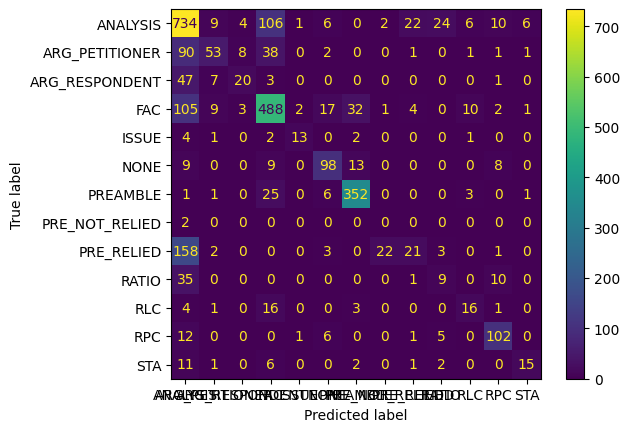

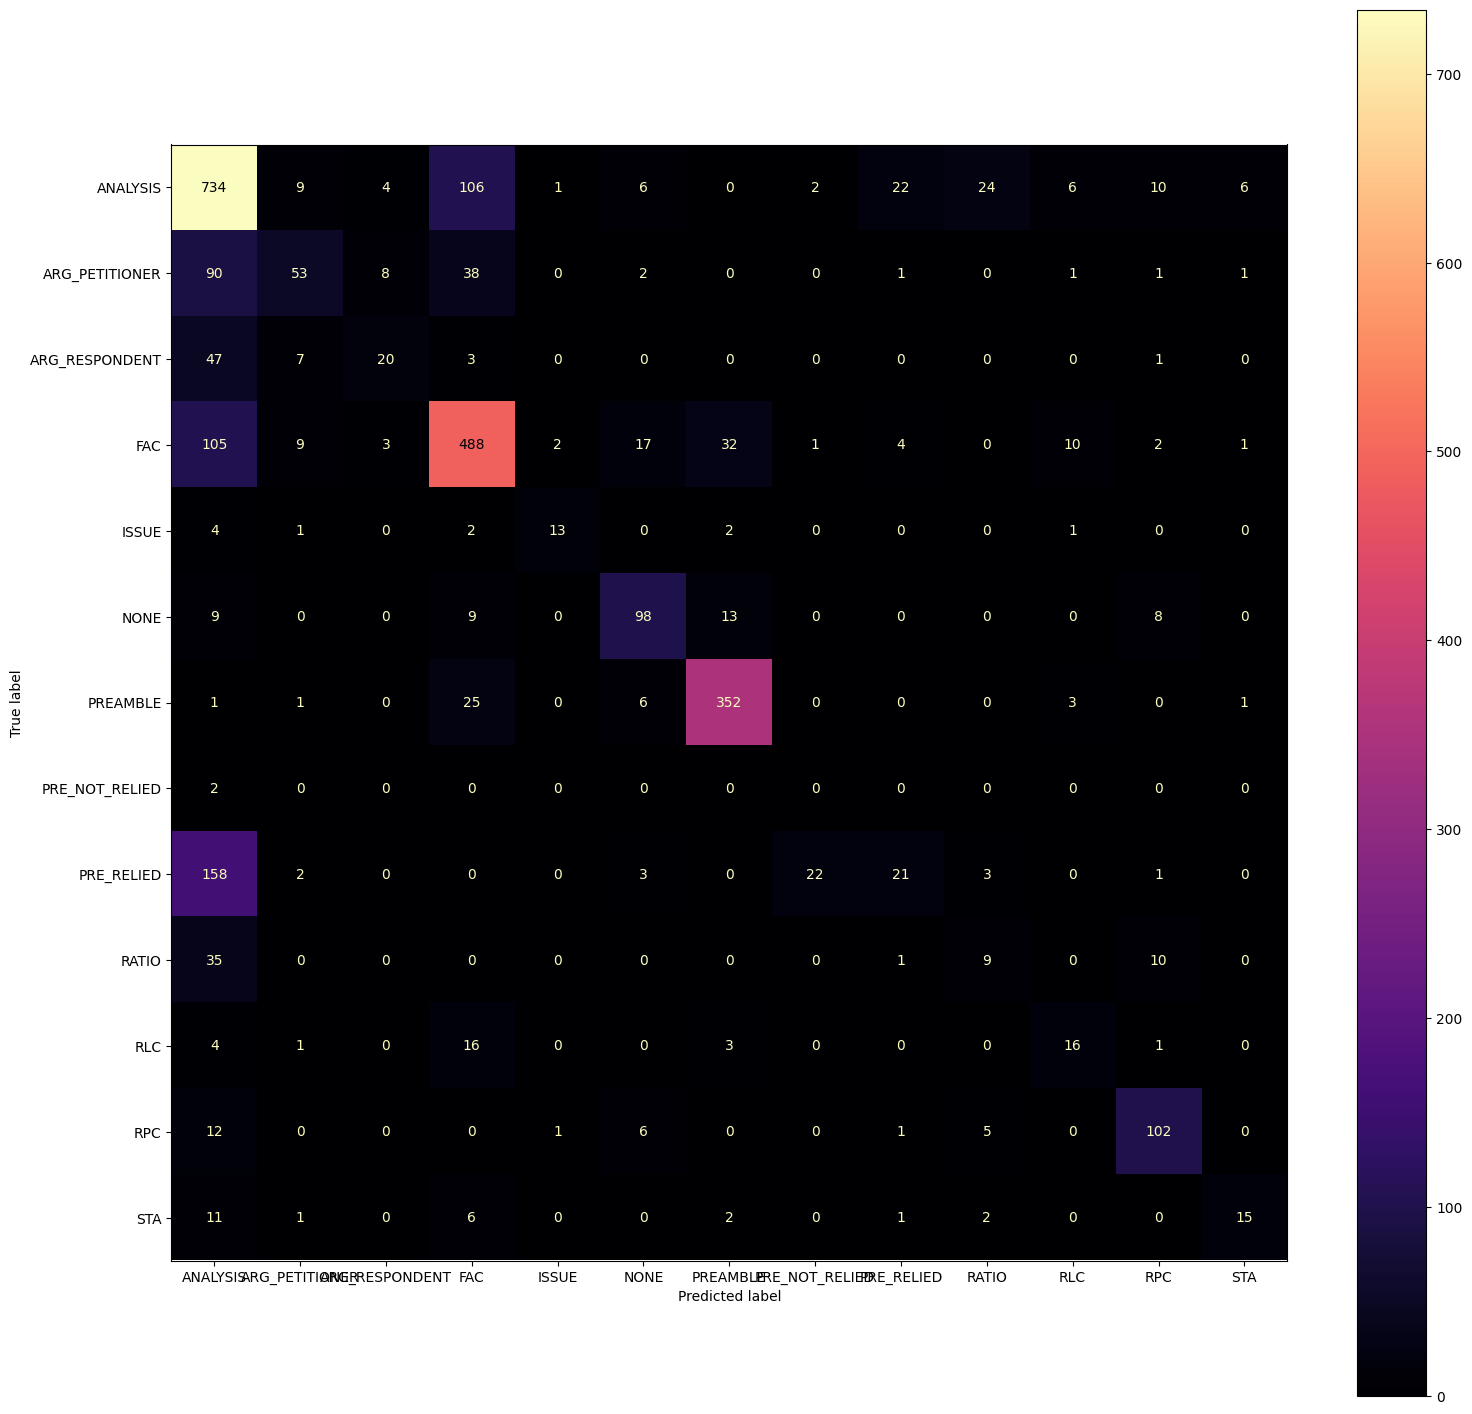

In [ ]:
# Ground truth labels (vérité terrain) et prédictions
ground_truth_labels = dev['labels']
submission_labels = dev['pred']

# Calculez la matrice de confusion
confusion = confusion_matrix(ground_truth_labels, submission_labels)

# Affichez la matrice de confusion
print("Matrice de Confusion :")
print(confusion)

# Utilisez ConfusionMatrixDisplay.from_estimator pour afficher la matrice de confusion sous forme de graphique
display = ConfusionMatrixDisplay.from_estimator(classifier, dev, ground_truth_labels)

# Calculez l'accuracy (précision globale)
accuracy = accuracy_score(ground_truth_labels, submission_labels)
print(f"Accuracy : {accuracy:.2f}")

fig, ax = plt.subplots(figsize=(18,18))

# Affichez la matrice de confusion sous forme de graphique
display.plot(ax=ax,cmap='magma', values_format='d')

    Métrique  Entraînement  Validation
0  Précision          0.91        0.65
1     Rappel          0.90        0.66
2         F1          0.90        0.64


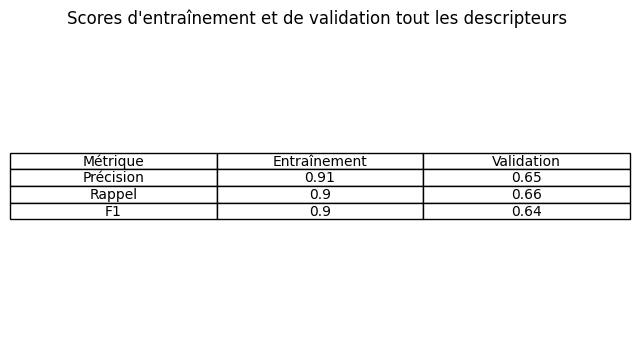

In [ ]:
# Erreur d'entraînement :
ground_truth_labels_train = train['labels']
submission_labels_train = train['pred']

precision_train, recall_train, f1_train, _ = precision_recall_fscore_support(
    ground_truth_labels_train, submission_labels_train, average='weighted'
)

# Erreur de validation
ground_truth_labels_dev = dev['labels']
submission_labels_dev = dev['pred']

precision_dev, recall_dev, f1_dev, _ = precision_recall_fscore_support(
    ground_truth_labels_dev, submission_labels_dev, average='weighted'
)

# Créez un DataFrame pour afficher les scores
scores_df = pd.DataFrame({
    'Métrique': ['Précision', 'Rappel', 'F1'],
    'Entraînement': [precision_train, recall_train, f1_train],
    'Validation': [precision_dev, recall_dev, f1_dev]
})

# Formatez les valeurs avec une précision de .2f
scores_df = scores_df.round(2)

# Affichez le DataFrame sous forme de tableau
print(scores_df)

# Affichez le tableau sous forme de plot
plt.figure(figsize=(8, 4))
plt.title('Scores d\'entraînement et de validation tout les descripteurs ')
plt.axis('tight')
plt.axis('off')
plt.table(cellText=scores_df.values, colLabels=scores_df.columns, cellLoc='center', loc='center')
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2b9c6c12-1844-464f-a8bd-5ce592d50499' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>